# Offline Replayer Evaluation IV - Movielens
> Evaluating bandits offline with replay method on movielens dataset

- toc: true
- badges: true
- comments: true
- categories: [bandit, movie]
- image: 

## Environment setup

### Import libraries

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from tqdm import tqdm

from scipy.stats import norm, beta
from abc import ABC, abstractmethod

### Loading data

In [17]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

rating_df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'], usecols=['movie_id', 'rating'])
rating_df.columns = ['movieId', 'rating']
rating_df.head()

--2021-06-18 08:34:11--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.3’

ml-100k.zip.3       100%[===================>]   4.70M  8.82MB/s    in 0.5s    

2021-06-18 08:34:12 (8.82 MB/s) - ‘ml-100k.zip.3’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


,movieId,rating
0,242,3
1,302,3
2,377,1
3,51,2
4,346,1


### Util functions

In [21]:
def get_data(data, num_ratings, num_movies):
    """ Make each movieId/action uniformly distributed """
    # filters out movies with less than `num_ratings` ratings
    movies = data.groupby('movieId').agg({'rating': 'count'})
    if num_movies is not None:
        movies_to_keep = movies[(movies['rating'] >= num_ratings)].sample(
            n=num_movies, random_state=12).index
    else:
        movies_to_keep = movies[(movies['rating'] >= num_ratings)].index
    data = data[data['movieId'].isin(movies_to_keep)]
    # take a random sample of size `num_ratings` for each movie
    data = data.groupby('movieId').sample(n=num_ratings, random_state=42)
    # shuffle rows to randomize data stream
    data = data.sample(frac=1, random_state=42)
    # reset index to create pseudo-timestamp index
    data = data.reset_index(drop=True)
    return data


# Plot ################################################################

def plot_rewards(*policies, title=None):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    fig.suptitle(title)
    for policy in policies:
        # get cumulative rewards
        cumsum_rewards = policy.history.reward.cumsum()
        # get average rewards
        timesteps = np.arange(len(cumsum_rewards)) + 1
        avg_rewards = cumsum_rewards / timesteps
        # plots
        ax1.plot(timesteps, avg_rewards, label=policy.name)
        ax2.plot(timesteps, cumsum_rewards, label=policy.name)
    #
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.set_xlabel('time step')
    ax1.set_ylabel('average reward')
    ax1.legend(loc='lower right')
    #
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax2.set_xlabel('time step')
    ax2.set_ylabel('cumulative reward')
    ax2.legend(loc='lower right')
    #
    plt.tight_layout()
    plt.show()


def plot_action_values(*policies):
    fig, axs = plt.subplots(nrows=1, ncols=len(policies), figsize=(15,5), squeeze=False)
    fig.suptitle("Action scores")
    axs = axs.ravel()
    for i, policy in enumerate(policies):
        cbar = True if i == len(axs)-1 else False
        sns.heatmap(policy.scores_log.T, ax=axs[i], vmin=2.5, vmax=5, cmap='hot',
                    cbar=cbar, xticklabels=1000, yticklabels=False)
        axs[i].set_xlabel('time step')
        axs[i].title.set_text(policy.name)
    axs[0].set_ylabel('movieId')
    plt.tight_layout()
    plt.show()

### Set variables

In [20]:
NUM_RATINGS = 30        # with full dataset  -> 10000
                        # with small dataset -> 30
NUM_MOVIES = None
SLATE_SIZE = 5
BATCH_SIZE = 100        # with replay eval   -> 100
                        # with simulated env -> 1
STREAM_LENGTH = 150     # with full dataset  -> 50000
                        # with small dataset -> 150
MODE = 'replay'         # 'replay' or 'sim'
SCORES_LOG = False      # logging movie scores or not

In [22]:
# get data
logged_events = get_data(rating_df, NUM_RATINGS, NUM_MOVIES)

## Create agents

In [9]:
# Abstract Base Policy ###############################################

class ABPolicy(ABC):
    def __init__(self, bandit, slate_size, scores_logging):
        self.name = None
        self.slate_size = slate_size
        self.history = pd.DataFrame(data=None, columns=['movieId', 'reward'])
        if scores_logging is True:
            self.scores_log = pd.DataFrame(data=None, columns=bandit.actions)
        else:
            self.scores_log = None

    @abstractmethod
    def get_recommendations(self):
        ...

    def update(self, rewards):
        # append new events to history
        self.history = self.history.append(rewards, ignore_index=True)
    
    def _sort_actions(self, scores):
        """ Sort actions by score and shuffle actions with same score
            Inputs:
                scores: pandas.Series with actions as index """
        sorted_actions = sorted(
            scores.sample(frac=1).index,
            key=lambda idx: scores.loc[idx],
            reverse=True)
        return sorted_actions

    def _update_scores_history(self, scores):
        if self.scores_log is not None:
            self.scores_log = self.scores_log.append(
                pd.DataFrame(
                    data=scores.to_numpy().reshape((1,-1)),
                    columns=self.scores_log.columns),
                ignore_index=True)
            self.scores_log = self.scores_log.astype('float')



# Epsilon Greedy Policy ##############################################

class EpsilonGreedy(ABPolicy):
    def __init__(self, bandit, epsilon, slate_size=1, scores_logging=False):
        super(EpsilonGreedy, self).__init__(bandit, slate_size, scores_logging)
        self.name = '{}-Greedy'.format(epsilon)
        self.epsilon = epsilon
        self.action_values = pd.DataFrame(data=0, columns=['value', 'count'],
                                          index=bandit.actions)

    def get_recommendations(self):
        # sort actions by value and shuffle actions with same value
        sorted_actions = self._sort_actions(self.action_values['value'])
        # choose recommendations
        if np.random.random() < self.epsilon:
            recs = np.random.choice(sorted_actions[self.slate_size:],
                                    size=self.slate_size, replace=False)
        else:
            recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(self.action_values['value'])
        return recs

    def update(self, rewards):
        super(EpsilonGreedy, self).update(rewards)
        # update action values
        for _, (movieId, reward) in rewards.iterrows():
            value = self.action_values.loc[movieId, 'value']
            N = self.action_values.loc[movieId, 'count']
            self.action_values.loc[movieId, 'value'] = (value * N + reward) / (N + 1)
            self.action_values.loc[movieId, 'count'] += 1
    

# Upper Confidence Bound Policy ######################################

class UCB1(ABPolicy):
    def __init__(self, bandit, slate_size=1, scores_logging=False):
        super(UCB1, self).__init__(bandit, slate_size, scores_logging)
        self.name = 'UCB1'
        self.action_values = pd.DataFrame(data=0, columns=['value', 'count'],
                                          index=bandit.actions)

    def get_recommendations(self):
        # compute UCB for each action
        current_step = len(self.history)
        if current_step > 0:
            scores = self.action_values['count'].apply(
                lambda N: np.sqrt(2*np.log(current_step) / N) if N > 0 else np.Inf)
            scores = scores + self.action_values['value']
        else:
            scores = pd.Series(data=np.Inf, index=self.action_values.index)
        # sort actions by score and shuffle actions with same score
        sorted_actions = self._sort_actions(scores)
        # choose recommendations
        recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(scores)
        return recs

    def update(self, rewards):
        super(UCB1, self).update(rewards)
        # update action values
        for _, (movieId, reward) in rewards.iterrows():
            value = self.action_values.loc[movieId, 'value']
            N = self.action_values.loc[movieId, 'count']
            self.action_values.loc[movieId, 'value'] = (value * N + reward) / (N + 1)
            self.action_values.loc[movieId, 'count'] += 1


# Thompson Sampling Policy ###########################################

class TS(ABPolicy):
    def __init__(self, bandit, slate_size=1, scores_logging=False):
        super(TS, self).__init__(bandit, slate_size, scores_logging)
        self.name = 'Thompson Sampling'
        self.beta_params = pd.DataFrame(data=1, columns=['alpha', 'beta'],
                                        index=bandit.actions)
    
    def get_recommendations(self):
        # sample expected value for each action
        expected_values = pd.Series(
            data=4.5 * beta.rvs(self.beta_params['alpha'], self.beta_params['beta']) + 0.5,
            index=self.beta_params.index)
        # sort actions by value and shuffle actions with same value
        sorted_actions = self._sort_actions(expected_values)
        # choose recommendations
        recs = sorted_actions[:self.slate_size]
        # update history of action scores
        self._update_scores_history(expected_values)
        return recs

    def update(self, rewards):
        super(TS, self).update(rewards)
        # update action value distribution prior
        for _, (movieId, reward) in rewards.iterrows():
            self.beta_params.loc[movieId, 'alpha'] += (reward - 0.5) / 4.5
            self.beta_params.loc[movieId, 'beta'] += (5.0 - reward) / 4.5

In [10]:
class ReplayBandit():
    """ Implementation of a bandit problem with replay evaluation """
    def __init__(self, logged_events, batch_size=1):
        self.events = logged_events.rename(columns={'rating': 'reward'})
        self.actions = np.sort(logged_events['movieId'].unique())
        self.batch_size = batch_size
        self.stream_length = len(self.events) // batch_size
    
    def get_rewards(self, recommendations, n_event):
        # generate events
        idx = n_event * self.batch_size
        events =  self.events.iloc[idx:idx+self.batch_size]
        # keep only events that match with the recommendation slate
        rewards = events[events['movieId'].isin(recommendations)]
        return rewards

In [23]:
bandit = ReplayBandit(logged_events, BATCH_SIZE)
STREAM_LENGTH = bandit.stream_length
title="rewards for bandit problem with replay evaluation"

print("NUMBER OF MOVIES/ACTIONS: {}".format(len(bandit.actions)))

NUMBER OF MOVIES/ACTIONS: 806


In [24]:
# instantiate policies
policies = [
    EpsilonGreedy(bandit, epsilon=0.1, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    UCB1(bandit, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    TS(bandit, slate_size=SLATE_SIZE, scores_logging=SCORES_LOG),
    ]

In [25]:
# evaluate policies
for policy in policies:
    print("POLICY: {}".format(policy.name))
    for i in tqdm(range(STREAM_LENGTH), ascii=True):
        recs = policy.get_recommendations()
        rewards = bandit.get_rewards(recs, i)
        policy.update(rewards)
    print("HISTORY LENGTH: {}".format(len(policy.history)))
    print()

  4%|3         | 9/241 [00:00<00:02, 85.23it/s]

POLICY: 0.1-Greedy


  4%|3         | 9/241 [00:00<00:02, 82.17it/s]

HISTORY LENGTH: 133

POLICY: UCB1


  3%|3         | 8/241 [00:00<00:02, 78.25it/s]

HISTORY LENGTH: 144

POLICY: Thompson Sampling


100%|##########| 241/241 [00:03<00:00, 78.49it/s]

HISTORY LENGTH: 141



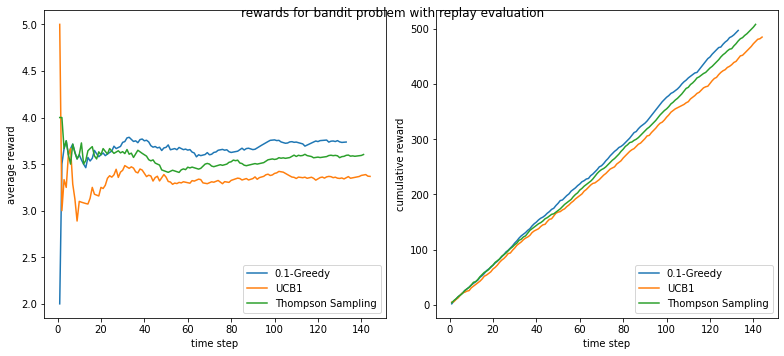

In [26]:
# plot results
plot_rewards(*policies, title=title)
if SCORES_LOG is True:
    plot_action_values(*policies)